In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.dqn.basic

In [ ]:
#|export
# Python native modules
import os
from collections import deque
from typing import Callable
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torchdata.dataloader2 import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *
import numpy as np
# Local modules
from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.dataloader2_ext import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.vscode_visualizers import *
from fastrl.learner.core import *
from fastrl.torch_core import *
from fastrl.data.dataloader2 import *

# DQN Basic
> Core DQN modules, pipes, and tooling

## Model

In [ ]:
#|export
class DQN(Module):
    def __init__(self,
                 state_sz:int,  # The input dim of the state
                 action_sz:int, # The output dim of the actions
                 hidden=512,    # Number of neurons connected between the 2 input/output layers
                 head_layer:Module=Linear, # DQN extensions such as Dueling DQNs have custom heads
                 activition_fn:Module=ReLU # The activiation fn used by `DQN`
                ):
        self.layers=Sequential(
            Linear(state_sz,hidden),
            activition_fn(),
            head_layer(hidden,action_sz),
        )
    def forward(self,x): return self.layers(x)


## Agent

In [ ]:
#|export
DataPipeAugmentationFn = Callable[[DataPipe],Optional[DataPipe]]

def DQNAgent(
    model,
    logger_bases=None,
    min_epsilon=0.02,
    max_epsilon=1,
    max_steps=1000,
    device='cpu',
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
)->AgentHead:
    agent_base = AgentBase(model,logger_bases=ifnone(logger_bases,[CacheLoggerBase()]))
    agent = StepFieldSelector(agent_base,field='state')
    agent = InputInjester(agent)
    agent = SimpleModelRunner(agent)
    agent = ArgMaxer(agent)
    agent = EpsilonSelector(agent,min_epsilon=min_epsilon,max_epsilon=max_epsilon,max_steps=max_steps,device=device)
    if agent_base.logger_bases is not None: 
        agent = EpsilonCollector(agent)
    agent = ArgMaxer(agent,only_idx=True)
    agent = NumpyConverter(agent)
    agent = PyPrimativeConverter(agent)
    agent = AgentHead(agent)
    
    for fn in ifnone(dp_augmentation_fns,[]):
        result = fn(agent)
        if result is not None: agent = result
    return agent

In [ ]:
torch.manual_seed(0)
model = DQN(4,2)

agent = DQNAgent(model)

In [ ]:
input_tensor = tensor([1,2,3,4]).float()
step = SimpleStep(state=input_tensor)

for action in agent([step]):
    print(action)
    
test_eq(input_tensor,tensor([1., 2., 3., 4.]))

1


In [ ]:
from fastrl.envs.gym import *

In [ ]:
AgentHead.debug=True

In [ ]:
# Setup Logger
logger_base = ProgressBarLogger()

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)

agent = DQNAgent(model,[logger_base])

block = DataBlock(
    GymTransformBlock(agent,n=10)
)
# dls = L(block.dataloaders(['CartPole-v1']*1,n=10,bs=1))
pipes = L(block.datapipes(['CartPole-v1']*1))

# list(dls[0])
list(pipes[0])
traverse(agent)

{139835997488656: (AgentHead,
  {139835997488848: (PyPrimativeConverter,
    {139835997489168: (NumpyConverter,
      {139835997490512: (ArgMaxer,
        {139835997489104: (EpsilonCollector,
          {139835791724432: (EpsilonSelector,
            {139835791724368: (ArgMaxer,
              {139835791808976: (SimpleModelRunner,
                {139835791808912: (InputInjester,
                  {139835791808784: (StepFieldSelector,
                    {139837965380880: (AgentBase,
                      {139835791808400: (ProgressBarLogger, {})})})}),
                 139837965380880: (AgentBase,
                  {139835791808400: (ProgressBarLogger, {})})})}),
             139837965380880: (AgentBase,
              {139835791808400: (ProgressBarLogger, {})})})})})})}),
   139837965380880: (AgentBase, {139835791808400: (ProgressBarLogger, {})})})}

## Training DataPipes

In [ ]:
#|export
class QCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.done_mask = batch.terminated.reshape(-1,)
            self.learner.next_q = self.learner.model(batch.next_state)
            self.learner.next_q = self.learner.next_q.max(dim=1).values.reshape(-1,1)
            self.learner.next_q[self.learner.done_mask] = 0 
            yield batch

In [ ]:
#|export
class TargetCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = None
        
    def __iter__(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.targets = batch.reward+self.learner.next_q*(self.discount**self.nsteps)
            self.learner.pred = self.learner.model(batch.state)
            self.learner.target_qs = self.learner.pred.clone()
            self.learner.target_qs.scatter_(1,batch.action.long(),self.learner.targets)
            yield batch

In [ ]:
#|export
class LossCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe,discount=0.99,nsteps=1):
        self.source_datapipe = source_datapipe
        self.discount = discount
        self.nsteps = nsteps
        self.learner = find_dp(traverse(self),LearnerBase)
        
    def __iter__(self):
        for batch in self.source_datapipe:
            self.learner.loss_grad = self.learner.loss_func(self.learner.pred, self.learner.target_qs)
            yield batch

In [ ]:
#|export
class ModelLearnCalc(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe
        
    def __iter__(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        for batch in self.source_datapipe:
            self.learner.loss_grad.backward()
            self.learner.opt.step()
            self.learner.opt.zero_grad()
            self.learner.loss = self.learner.loss_grad.clone()
            yield self.learner.loss

In [ ]:
#|export
class LossCollector(LogCollector):
    header:str='loss'

    def __init__(self,
            source_datapipe, # The parent datapipe, likely the one to collect metrics from
        ):
        self.source_datapipe = source_datapipe
        self.main_buffers = None
        
    def __iter__(self):
        self.learner = find_dp(traverse(self),LearnerBase)
        for i,steps in enumerate(self.source_datapipe):
            # if i==0: self.push_header('loss')
            for q in self.main_buffers: q.append(Record('loss',self.learner.loss.cpu().detach().numpy()))
            yield steps

In [ ]:
#|export
def DQNLearner(
    model,
    dls,
    logger_bases=None,
    loss_func=MSELoss(),
    opt=AdamW,
    lr=0.005,
    bs=128,
    max_sz=10000,
    nsteps=1,
    device=None,
    batches=None,
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
) -> LearnerHead:
    learner = LearnerBase(model,dls,batches=batches,loss_func=loss_func,opt=opt(model.parameters(),lr=lr))
    learner = LoggerBasePassThrough(learner,logger_bases)
    learner = BatchCollector(learner,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner)
    for logger_base in L(logger_bases): learner = logger_base.connect_source_datapipe(learner)
    if logger_bases: 
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner,device=device)
    learner = QCalc(learner)
    learner = TargetCalc(learner,nsteps=nsteps)
    learner = LossCalc(learner)
    learner = ModelLearnCalc(learner)
    if logger_bases: 
        learner = LossCollector(learner)
    learner = LearnerHead(learner)
    
    for fn in ifnone(dp_augmentation_fns,[]):
        result = fn(learner)
        if result is not None: learner = result
    
    return learner

Try training with basic defaults...

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2).cuda()
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000,device='cuda')
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=1,nskips=1,firstlast=False,bs=1)
)

dls = L(block.dataloaders(['CartPole-v1']*1,num_workers=0))

# Setup the Learner
learner = DQNLearner(model,dls,batches=4,#1000,
                     logger_bases=[logger_base],
                      bs=2,#128,
                      max_sz=100_000,device='cuda')
# learner.fit(3)
learner.fit(2)



loss,episode,rolling_reward,epoch,batch,epsilon
0.44844115,1,None,1,5,0.998500
0.41163164,1,None,1,5,0.997500


If we try a regular DQN with nsteps/nskips it doesnt really converge after 130. We cant expect stability at all, and im pretty sure that nsteps (correctly) tries to reduce to number of duplicated states so that the agent can sample more unique state transitions. The problem with this is that the base dqn is not stable, so giving it lots of "new" stuff, im not sure helps. In otherwords, its going to forget the old stuff very quickly, and having duplicate states helps "remind it"

In [ ]:
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(4,2)
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True) # We basically merge 2 steps into 1 and skip. 
)
# pipes = L(block.datapipes(['CartPole-v1']*1,n=10))
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,batches=1000,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001)
# learner.fit(3)
# learner.fit(20)

In [ ]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.pipes.map.transforms import *
from fastrl.envs.gym import gymnasium as gymTypeTransform,GymStepper
from fastrl.loggers.core import *
from fastrl.loggers.jupyter_visualizers import *
from fastrl.loggers.vscode_visualizers import *

Creating gif from 100 frames


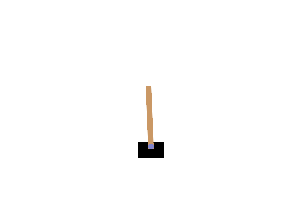

In [ ]:
#|hide
#|eval: false
model.eval()

pipe = GymTransformBlock(agent=agent,n=100,seed=0,include_images=True)(['CartPole-v1'])
pipe = VSCodeTransformBlock()(pipe)

list(pipe);
pipe.show()

In [ ]:
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = DQN(8,4)
# Setup the Agent
agent = DQNAgent(model,[logger_base])
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,bs=1,n=1000)
)
dls = L(block.dataloaders(['LunarLander-v2']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base])
learner.fit(3)
# learner.fit(30)

loss,episode,rolling_reward,epoch,batch,epsilon
0.44493392,9,-174.366881,1,1000,0.020000
0.57215977,11,-149.441252,2,1000,0.020000
0.37252918,11,-149.441252,2,1000,0.020000


In [ ]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.pipes.map.transforms import *
from fastrl.envs.gym import gymnasium as gymTypeTransform,GymStepper
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock

Creating gif from 100 frames


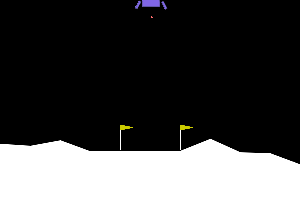

In [ ]:
#|hide
#|eval: false
pipe = GymTransformBlock(agent=agent,n=100,seed=None,include_images=True)(['LunarLander-v2'])
pipe = VSCodeTransformBlock()(pipe)

L(pipe);
pipe.show(step=2)

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()